# 주제 : 추천 시스템 - 영화 데이터셋과 Rating Matrix를 활용하여 추천 모델 학습하기
----------

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.
    
    
## 데이터 소개
    - 이번 주제는 MovieLens Dataset을 사용합니다.
    - 파일은 두 개 이며, 각각의 컬럼은 아래와 같습니다.
    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    
- 데이터 출처: https://grouplens.org/datasets/movielens/


## 최종 목표
    - CF(Collaborative Filtering) 기반 추천 모델의 이해
    - Matrix Factorization 기반 추천 모델의 이해
    - KNN, SVD 알고리즘에 대한 이해
    - 훈련된 모델의 결과를 해석하는 방법 습득
    - 모델의 추천 결과를 평가하는 방법 습득

- 출제자 : 윤기태 강사
---

## Step 1. 데이터 전처리 과정

### 문제 1. 데이터 불러오기

In [ ]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### 문제 2. EDA - 사용자 수와 영화의 수 탐색

In [ ]:
# unique() 함수로 사용자 수와 영화 수 탐색
len(rating_df['user_id'].unique())

6040

In [ ]:
len(movie_df['movie_id'].unique())

3883

### 문제 3. EDA - 영화 평가 점수의 분포 탐색

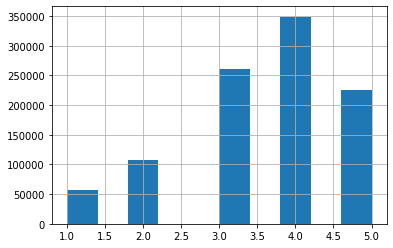

In [ ]:
# hist() 함수로 히스토그램 그래프 생성'
import matplotlib.pyplot as plt
rating_df['rating'].hist()

## Step 2. CF-based 모델링 (KNN)

### Rating Matrix와 Colaborative Filtering (CF)
----------

#### Rating Matrix

![rating matrix](https://www.researchgate.net/profile/Giuseppe_Manco3/publication/220907096/figure/fig1/AS:305570830667776@1449865171054/An-example-of-rating-matrix.png)

    1. User를 Row, Item을 Column으로 하며 Value를 Rating으로 하는 행렬
    2. Rating의 종류
      - Explicit Feedback : 영화 점수, 리뷰 점수, 좋아요 표시...
      - Implicit Feedback : 조회, 시청, 구매, 찜 표시...
    3. Rating Matrix를 추천 모델로 활용하는 방법
      - Colaborative Filtering (CF)
      - Matrix Factorization (MF)

-----

#### Colaborative Filtering (CF)

![CF](https://t1.daumcdn.net/cfile/tistory/9970CE495AF71C0C06)

> 고객들의 선호도와 관심 표현을 바탕으로 선호도, 관심에서 비슷한 패턴을 가진 고객들을 식별해 내는 기법이다. 비슷한 취향을 가진 고객들에게 서로 아직 구매하지 않은 상품들은 교차 추천하거나 분류된 고객의 취향이나 생활 형태에 따라 관련 상품을 추천하는 형태의 서비스를 제공하기 위해 사용된다.
    
    1. User-based
    2. Item-based

-----

### 문제 4. 모델링 - Train/Test 데이터 분리

In [ ]:
!pip install surprise

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리
reader = Reader(rating_scale = (1,5)) #평가 점수 범위
data = Dataset.load_from_df(rating_df[['user_id', 'movie_id', 'rating']], reader) #불러온 평가데이터를 읽음
trainset, testset = train_test_split(data, test_size = 0.25) #학습,테스트 데이터로 분리

### 문제 5. 모델링 - KNN 모델 학습

-----

#### KNN (K-Nearest Neighbor) 알고리즘

![knn](http://i.imgur.com/gLBo1gX.png)

    [KNN의 대략적인 이해]
    1. 새로운(혹은 특정한) 데이터 포인트 X가 있을 때, X와 가장 유사한 k개를 이용하여 데이터 포인트 X의 위치를 찾는 알고리즘
    2. euclidean distance, cosine similarity 등을 기준으로 유사한 k개를 계산
    3. 분류(classification) 문제의 경우는 k개의 포인트에서 가장 많이 등장한 class로 할당
    4. 예측(regression) 문제의 경우는 k개 포인트의 평균 값, 혹은 가중치 값 등으로 X의 값을 예측

#### Surprise의 KNN

> A basic collaborative filtering algorithm. The prediction 𝑟̂ 𝑢𝑖 is set as

![suprise knn](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/knn.png)

###### (https://surprise.readthedocs.io/en/stable/knn_inspired.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. User-based CF
    2. 유저 A와 가장 영화를 유사하게 평가한 유저 k명을 선정
    3. k명의 유저가 영화 a를 평가한 점수를 활용하여 위의 식대로 점수를 계산함
    4. 이와 같은 방식으로 Rating Matrix를 완성
-----
    [Similarity]
    1. 가장 일반적인 Similarity 계산 방식은 cosine similarity
    2. 다른 방식은 euclidean distance, jaccard index, pearson correlation 등이 있음

![cosine](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/cosine.png)
-----

In [ ]:
# KNN 이해를 돕기 위한 참고 코드
ab = (0.9 * 4) + (0.8 * 3) + (0.7 * 5) + (0.6 * 1)
bb = (0.9) + 0.8 + 0.7 + 0.6

ab/bb

3.3666666666666663

In [ ]:
from surprise import KNNBasic #모델 완성시켜주는 클래스

# KNNBasic 모델 학습
algo = KNNBasic(k = 40, min_k = 1, sim_options={'user_based': True, 'name':'cosine'}) #sim_options. itembase 또는 user base, 어떤 방식으로 유사도 찾을지
algo.fit(trainset)
predictions = algo.test(testset)
predictions

Computing the cosine similarity matrix...
Done computing similarity matrix.


[Prediction(uid=2528, iid=47, r_ui=5.0, est=4.349700057630791, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2870, iid=300, r_ui=2.0, est=3.624371084247728, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3389, iid=161, r_ui=2.0, est=3.9006379488235483, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5387, iid=2629, r_ui=1.0, est=2.8504909534772302, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3090, iid=480, r_ui=3.0, est=3.675, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=752, iid=2610, r_ui=4.0, est=3.947095887086454, details={'actual_k': 32, 'was_impossible': False}),
 Prediction(uid=4917, iid=1305, r_ui=3.0, est=3.8724585370037468, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=752, iid=3317, r_ui=5.0, est=4.174366660583689, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=4133, iid=1015, r_ui=4.0, est=3.7515538315281725, details={'actu

### 문제 6. 모델링 - RMSE 평가

In [ ]:
from surprise import accuracy #모델 평가 함수
accuracy.rmse(predictions)
# accuracy로 rmse 평가

RMSE: 0.9771


0.9770828989511757

### 문제 7. 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [ ]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
predictions = algo.test(testset[:20])

In [ ]:
predictions

[Prediction(uid=2528, iid=47, r_ui=5.0, est=4.349700057630791, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2870, iid=300, r_ui=2.0, est=3.624371084247728, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3389, iid=161, r_ui=2.0, est=3.9006379488235483, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5387, iid=2629, r_ui=1.0, est=2.8504909534772302, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3090, iid=480, r_ui=3.0, est=3.675, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=752, iid=2610, r_ui=4.0, est=3.947095887086454, details={'actual_k': 32, 'was_impossible': False}),
 Prediction(uid=4917, iid=1305, r_ui=3.0, est=3.8724585370037468, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=752, iid=3317, r_ui=5.0, est=4.174366660583689, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=4133, iid=1015, r_ui=4.0, est=3.7515538315281725, details={'actu

## Step 3. MF-based 모델링 (SVD)

### 문제 8. 모델링 - Train/Test 데이터 분리

In [ ]:
# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리
reader = Reader(rating_scale = (1,5)) #평가 점수 범위
data = Dataset.load_from_df(rating_df[['user_id', 'movie_id', 'rating']], reader) #불러온 평가데이터를 읽음
trainset, testset = train_test_split(data, test_size = 0.25) #학습,테스트 데이터로 분리

### 문제 9. 모델링 - SVD 모델 학습

-----

#### Matrix Factorization의 개념

![MF](https://t1.daumcdn.net/cfile/tistory/99EAC1455AF71F3E31)

![MF2](https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-3-319-65930-5_47/MediaObjects/455696_1_En_47_Fig3_HTML.gif)

    [MF의 대략적인 이해]
    1. 원래의 행렬을 다른 2개 행렬로 분해하고, 이를 다시 원래 모양으로 만드는 과정을 Factorization 이라고 함.
    2. 그 과정에서 Latent Factor 라는 것을 활용하여, 행과 열의 성질을 만들어낼 수 있음.
    3. latent factor를 충분히 많이 만들게 되면, 유저와 아이템의 성질을 벡터로 표현 가능.
    4. 일반적으로 지도 학습을 통해 P와 Q를 찾게 되고, 이를 Model-based CF 라고 하기도 함.

#### Surprise의 SVD

> The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization

> The prediction 𝑟̂ 𝑢𝑖 is set as:

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_1.png)

###### (https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. Model-based MF
    2. 이미 점수가 존재하는 r_ui를 기준으로 P, Q를 학습.
    3. 특정 epoch, 혹은 수렴 조건에 달할 때 까지 학습 (Gradient Descent)

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_2.png)

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_3.png)

-----

In [ ]:
from surprise import SVD

# SVD 모델 학습
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

### 문제 10. 모델링 - RMSE 평가

In [ ]:
# 앞에서와 동일하게 accuracy 함수로 rmse 평가
accuracy.rmse(predictions)

RMSE: 0.8789


0.8788581297250264

### 문제 11. 모델링 & 시각화 - RMSE를 개선하는 파라미터 튜닝 자동화

In [ ]:
import time

param_list = [10, 50, 100, 150, 200]
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in param_list:    
    train_start = time.time()
    algo = SVD(n_factors=n)
    algo.fit(trainset)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = algo.test(testset)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 18.49 seconds
RMSE of test dataset in SVD model, n_factors=10
RMSE: 0.8767
------------------------------------
training time of model: 32.42 seconds
RMSE of test dataset in SVD model, n_factors=50
RMSE: 0.8760
------------------------------------
training time of model: 46.79 seconds
RMSE of test dataset in SVD model, n_factors=100
RMSE: 0.8781
------------------------------------
training time of model: 63.15 seconds
RMSE of test dataset in SVD model, n_factors=150
RMSE: 0.8819
------------------------------------
training time of model: 81.05 seconds
RMSE of test dataset in SVD model, n_factors=200
RMSE: 0.8835
------------------------------------
searching n_factors is finish.


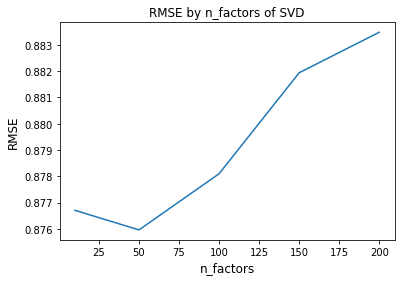

In [ ]:
# plt의 plot 함수로 결과 시각화
plt.plot(param_list, rmse_list_by_factors)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

### 문제 12. 모델 평가 - 최종 RMSE 평가

In [ ]:
# accuracy로 rmse 평가
algo = SVD(n_factors=50)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8764


0.8764474690935086

### 문제 13. 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [ ]:
predictions = algo.test(testset[:20])

for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 2605 | real rating : 3.0 | predicted rating : 2.7923995127888124
Item id 508 | real rating : 5.0 | predicted rating : 4.21670614083266
Item id 2571 | real rating : 4.0 | predicted rating : 3.5007495104852477
Item id 2628 | real rating : 2.0 | predicted rating : 2.8207794378014666
Item id 581 | real rating : 4.0 | predicted rating : 4.392038377416985
Item id 1196 | real rating : 5.0 | predicted rating : 4.238560127840165
Item id 2668 | real rating : 2.0 | predicted rating : 2.3415981170650615
Item id 1252 | real rating : 4.0 | predicted rating : 3.6376653163702763
Item id 2879 | real rating : 2.0 | predicted rating : 3.3702505924800508
Item id 1214 | real rating : 5.0 | predicted rating : 4.361438668811451
Item id 457 | real rating : 4.0 | predicted rating : 4.31488199208076
Item id 3861 | real rating : 4.0 | predicted rating : 3.7289099100178107
Item id 2163 | real rating : 5.0 | predicted rating : 3.0780130226236877
Item id 471 | real rating : 2.0 | predicted rating : 4.157402

## Step 4. 추천 결과 평가

-----

#### CF, MF 기반 추천시스템의 가정(한계)

    [가정 : 사용자의 과거 Preference는 미래에서도 동일하다]
    1. Time Series로 추정된 선호도가 아닌, Estimate 되거나 Factorized 된 점수
    2. A시점에 평가한 선호도와, B시점에 평가한 선호도가 동일 선에서 학습됨
    3. Test 데이터에 대한 평가 역시, 시간이 고려되지 않은 "랜덤한 빈공간 찾기" 식으로 평가됨

- 이번 챕터의 목표
  - `학습은 그렇다 치고, 평가라도 시간을 고려해서 해보자`

### 문제 14. 추천 결과 평가 - 사용자별 전체 시청리스트 추출

In [ ]:
# groupby와 apply 함수를 이용하여 사용자별 시청리스트 추출
user_watch_dict = rating_df.groupby('user_id')[['user_id','movie_id']].apply(lambda x: x['movie_id'].tolist()) #특정 유저별로 본 영화들을 하나의 리스트로 만듬

In [ ]:
user_watch_dict

user_id
1       [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2       [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3       [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4       [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5       [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
                              ...                        
6036    [571, 574, 2053, 2054, 2058, 588, 589, 4, 3005...
6037    [589, 3006, 1407, 2064, 2065, 593, 3015, 903, ...
6038    [1419, 920, 3088, 232, 1136, 1148, 1183, 2146,...
6039    [588, 2067, 1416, 3022, 3028, 2080, 2083, 2087...
6040    [573, 589, 1, 2068, 592, 593, 3016, 3017, 2070...
Length: 6040, dtype: object

### 문제 15. 추천 결과 평가 - 특정 시간 기준 사용자별 Train/Test 시청리스트 추출
추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

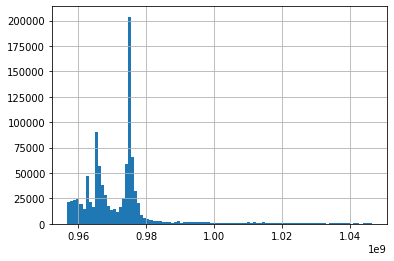

In [ ]:
# 시간별 시청 분포 탐색 
rating_df['time'].hist(bins=100)

In [ ]:
# 8:2 로 분할할 수 있는 시간 지정
that_time = rating_df['time'].quantile(q=0.8, interpolation='nearest')

In [ ]:
# 지정된 시간으로 데이터셋 분리
train_df = rating_df[rating_df['time']< that_time][['user_id','movie_id','rating']]
test_df = rating_df[rating_df['time'] >= that_time][['user_id','movie_id','rating']]

In [ ]:
# 특정 시간 이후를 대상으로 다시 한 번 사용자별 시청리스트 추출
train_df.shape

(800164, 3)

In [ ]:
len(train_df['user_id'].unique()) #기준 시간전 시청자

5400

In [ ]:
len(test_df['user_id'].unique()) #기준 시간 이후 시청자 -> 기준시간전 시청자가 일부 포함됐을수도 있고 새로운 시청자도 있을듯

1783

In [ ]:
user_watch_dict_test = test_df.groupby('user_id')[['user_id','movie_id']].apply(lambda x: x['movie_id'].tolist()) #특정 시간 기준으로 만든 테스트 데이터에 대한 유저별 영화 리스트
#즉 이를 통해 특정시간 이전에 있는 데이터를 학습해 특정시간이후(학습데이터 기준으로는 미래인 테스트 데이터)에 대한 추천 리스트를 볼 수 있다 

### 문제 16. 추천 결과 평가 - 모델 기반 사용자별 선호 시청리스트 추출

In [ ]:
# 위에서 추출한 학습 데이터셋으로 SVD 모델 다시 학습
data = Dataset.load_from_df(df = train_df, reader = reader)
train_data = data.build_full_trainset()
algo = SVD(n_factors = 50) #이전에 50이 가장 학습성능이 좋았음
algo.fit(train_data)

In [ ]:
# anti dataset 생성
test_data = train_data.build_anti_testset()

In [ ]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
predictions = algo.test(testset[:20])

In [ ]:
predictions = algo.test(test_data)
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in predictions:
  if uid in estimated_unwatched_dict:
    estimated_unwatched_dict[uid].append((iid, predicted_rating))
  else:
    estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

### 문제 17. 추천 결과 평가 - 예상 선호 리스트와 실제 시청리스트로 MAP@K 계산

-----

![confusion_matrix](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/confusion_matrix.png)

    [Confusion Matrix와 Recall]
    1. 분류 문제에서 사용하는 대표적인 평가 기준
    2. 무언가의 실제 클래스(binary), 그리고 예상한 클래스(binary)를 비교하기 위한 매트릭스
    3. 이 중 Precision은 흔히 "정확도" 이라고 불리는 지표로, 맞다고 예측한 것 중에 실제로 맞는 것의 비율을 의미함.

-----

    [추천시스템과 Precision, Recall]
    1. 추천시스템에 이를 대입해보자
    2. 유저A가 실제로 시청한 영화들을 a, 모델이 유저 A가 볼 것이라고 예측한 영화들을 b라고 가정
    3. 이 때 모델이 10개의 영화를 예측 했다면 Top 10 Precision 계산할 수 있음.
    4. Recall 역시 마찬가지의 방법으로 구할 수 있음.
    5. Precision과 Recall에 대한 선택 기준은 상황마다 다르지만, 추천시스템에서 일반적으로 사용하는 지표는 "MAP"
    6. MAP(Mean Average Precision) : 추천시스템에서는 각 유저마다의 Precision을 계산한 뒤, 이것을 모든 추천 대상 유저로 확장하여 평균적인 지표를 계산한 것이라고 볼 수 있음.

In [ ]:
# 4점 이상을 준 test 시청리스트만 추출
user_watch_dict_list_test = test_df[test_df['rating']>=4].groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())

In [ ]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3
for user in estimated_unwatched_dict:
  estimated_list = estimated_unwatched_dict[user].copy()
  estimated_list.sort(key=lambda tup: tup[1], reverse=True) #tup[1] 점수에 해당하는 부분. reverse -> 내림차순
  #리스트가 점수에따라 정렬이 됨
  try: #특정시점 이전에 영화를 본 유저중 특정시점 이후는 영화를 안봤을수도 있다 -> try except로 걸러줌 
    top_k_prefer_list = [movie[0] for movie in estimated_list[:k]] #높게 평가된 상위 k만 가져옴
    actual_watch_list = user_watch_dict_list_test[int(user)] #실제 영화평가중 4점 이상인것
    user_metric.append((user, top_k_prefer_list, actual_watch_list)) # 유저별로 예측ㄱ된 평가와 실제 평가
  except:
    print("list index out of range, exclude user " + str(user))

list index out of range, exclude user 636
list index out of range, exclude user 637
list index out of range, exclude user 638
list index out of range, exclude user 640
list index out of range, exclude user 642
list index out of range, exclude user 643
list index out of range, exclude user 644
list index out of range, exclude user 645
list index out of range, exclude user 647
list index out of range, exclude user 652
list index out of range, exclude user 653
list index out of range, exclude user 654
list index out of range, exclude user 655
list index out of range, exclude user 656
list index out of range, exclude user 657
list index out of range, exclude user 658
list index out of range, exclude user 659
list index out of range, exclude user 661
list index out of range, exclude user 662
list index out of range, exclude user 663
list index out of range, exclude user 665
list index out of range, exclude user 666
list index out of range, exclude user 668
list index out of range, exclude u

In [ ]:
user_metric

In [ ]:
# 유저 한 명의 Precision 계산
predictive_values = user_metric[0][1]
actual_values = set(user_metric[0][2])
tp = [pv for pv in predictive_values if pv in actual_values]
len(tp) / len(predictive_values)

In [ ]:
# user metric를 인자로 받는 일반화된 Precision 계산 함수 정의
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1] #예측한 상위 k개
    actual_values = set(user[2]) #실제로 4점이상 평가한 영화
    tp = [pv for pv in predictive_values if pv in actual_values] #precision 계산
    precision = len(tp) / len(predictive_values) #여기서 나온값 ex) 0.33 -> 추천한 3개중 1개는 정말 재밌게 봤다
    precision_list.append(precision) #각 유저별 precision 값을 저장
  return sum(precision_list) / len(precision_list) #유저 전반적으로 만족함을 평가한 값 -> 0.1449 -> 100개를 추천했다고 치면 14정도는 만족을 했다

In [ ]:
get_map(user_metric)

### 문제 18. 추천 결과 평가 & 시각화 - K 파라미터 별 추천 결과 시각화

In [ ]:
# user metric를 인자로 받는 일반화된 Precision 계산 함수 정의
def get_map_topk(k):
  user_metric = []
  for user in estimated_unwatched_dict:
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)
    try:
      top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
      actual_watch_list = user_watch_dict_list_test[user_watch_dict_list_test.index==user].values.tolist()[0]
      user_metric.append((user, top_k_prefer_list, actual_watch_list))
    except:
      pass
  
  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [ ]:
# 반복문, plot 함수를 활용하여 k 파라미터 튜닝 관찰 및 자동화
k_param_list = range(1,30)
map_list = []
for k in k_param_list:    
  map_list.append(get_map_topk(k))

In [ ]:
plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()